In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import random
from PIL import Image
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0
weather-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/weather-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
datadir = '/content/dataset'

In [6]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<ipython-input-7-5071b0e149dd>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i + 1)


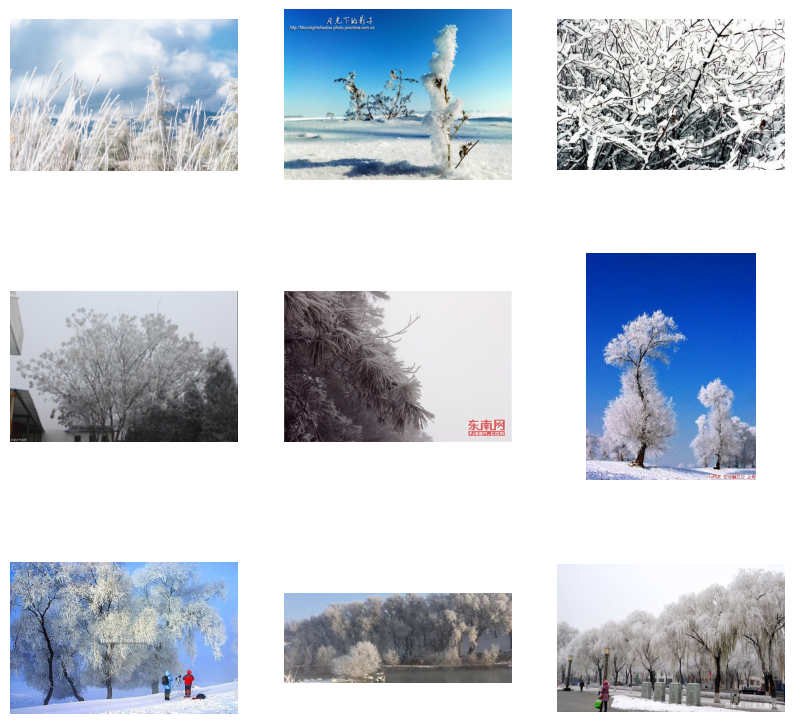

In [7]:
image_folder = '/content/dataset/rime'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
plt.figure(figsize=(10, 10))
plt.title('Rime images')
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image_path = os.path.join(image_folder, image_files[i])
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

plt.show()

<Axes: >

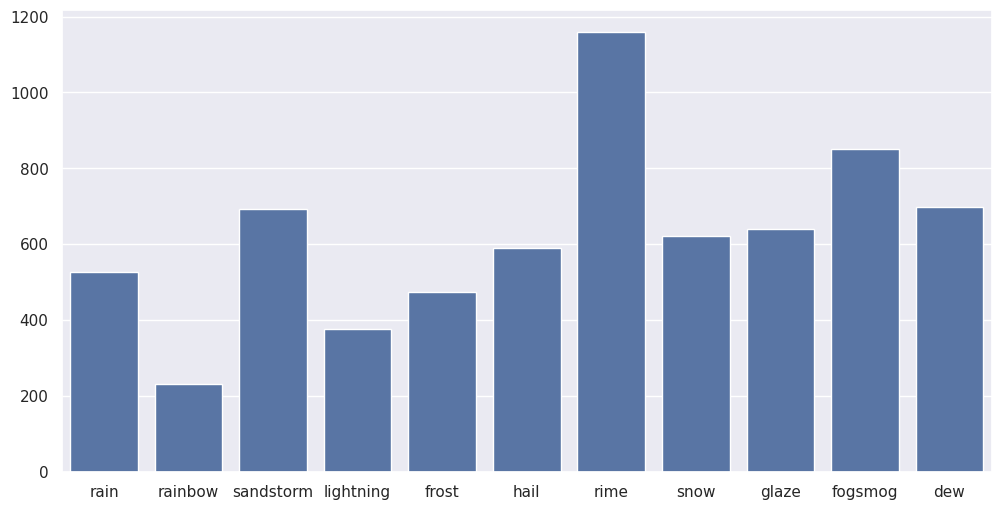

In [8]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

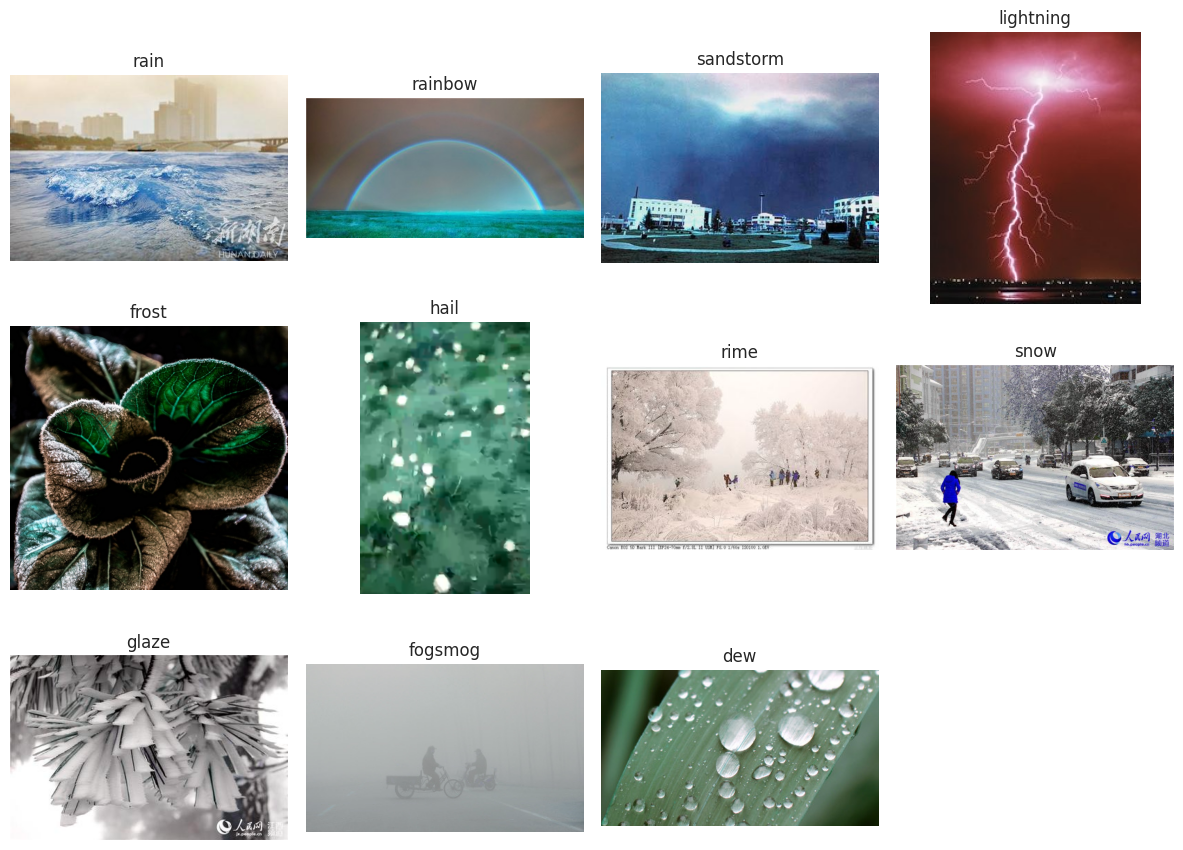

In [9]:
fig = plt.figure(figsize=(12, 12))
rows = 4
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(cl)

plt.tight_layout()
plt.show()

In [10]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [11]:
df.head()

,filepaths,labels
0,/content/dataset/rain/141.jpg,rain
1,/content/dataset/rain/1713.jpg,rain
2,/content/dataset/rain/1558.jpg,rain
3,/content/dataset/rain/1742.jpg,rain
4,/content/dataset/rain/1476.jpg,rain


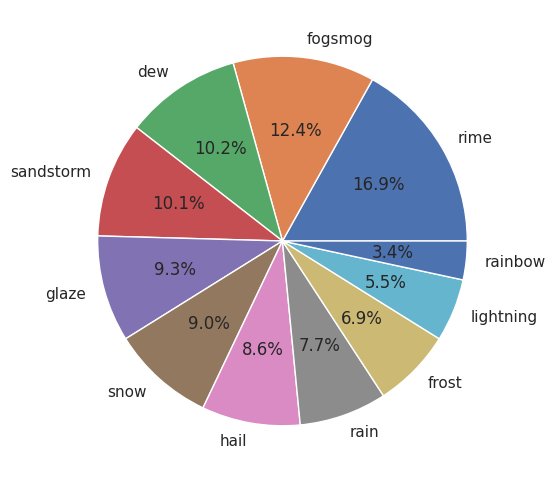

In [12]:
df['labels'].value_counts().plot(kind='pie', autopct='%1.1f%%')
_ = plt.ylabel('')

# **Lets Process the image for trainng and testing**

In [13]:
def process_images(filepaths,target_size=(224,224)):
  images = []
  for path in filepaths:
    img = load_img(path, target_size=target_size)
    img = img_to_array(img)
    img = img/255.0
    images.append(img)
  return np.array(images)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['filepaths'], df['labels'], test_size=0.2, random_state=42)

In [15]:
X_train = process_images(X_train)
X_test = process_images(X_test)

In [16]:
X_train.shape

(5489, 224, 224, 3)

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [18]:
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [19]:
y_train.shape

(5489, 11)

# **Lets Build the model**

In [20]:
model = Sequential()
model.add(Conv2D(16,(2,2),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(11,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 223, 223, 16)        │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 96800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       3,097,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,102,811 (11.84 MB)

 Trainable params: 3,102,779 (11.84 MB)

 Non-trainable params: 32 (128.00 B)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1,validation_data=(X_test, y_test))

Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.3316 - loss: 2.7697 - val_accuracy: 0.3598 - val_loss: 2.0164
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5235 - loss: 1.3678 - val_accuracy: 0.5018 - val_loss: 1.5391
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5913 - loss: 1.1268 - val_accuracy: 0.5331 - val_loss: 1.3478
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6782 - loss: 0.8954 - val_accuracy: 0.5965 - val_loss: 1.1842
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7562 - loss: 0.6988 - val_accuracy: 0.6358 - val_loss: 1.2071
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8107 - loss: 0.5641 - val_accuracy: 0.6402 - val_loss: 1.1635
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8648 - loss: 0.3980 - val_accuracy: 0.6074 - val_loss: 1.5554
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9025 - loss: 0.3150 - val_acc

In [24]:
model.evaluate(X_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6609 - loss: 1.4859


[1.4997336864471436, 0.6504005789756775]

In [26]:
model.save('weather.keras')

In [27]:
y_pred = model.predict(X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


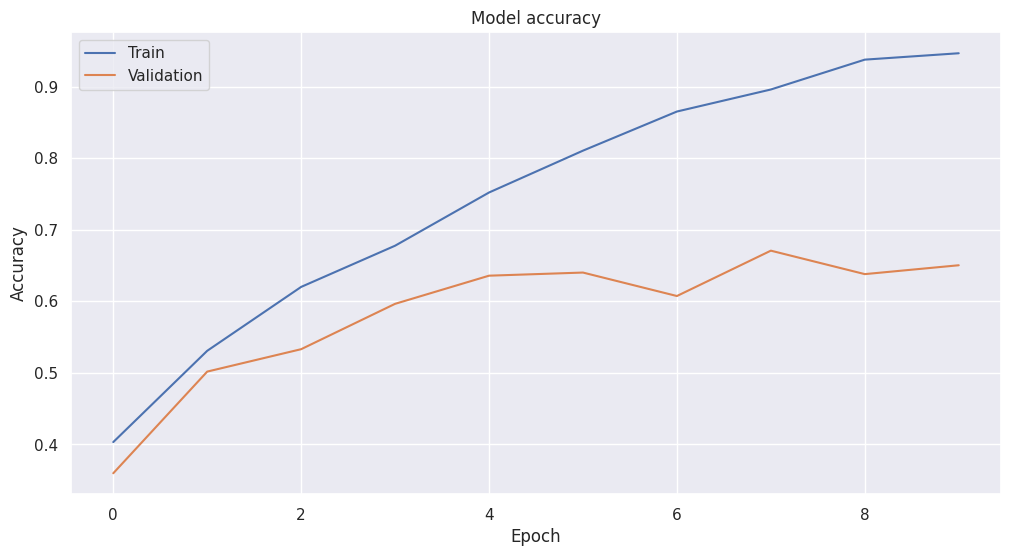

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

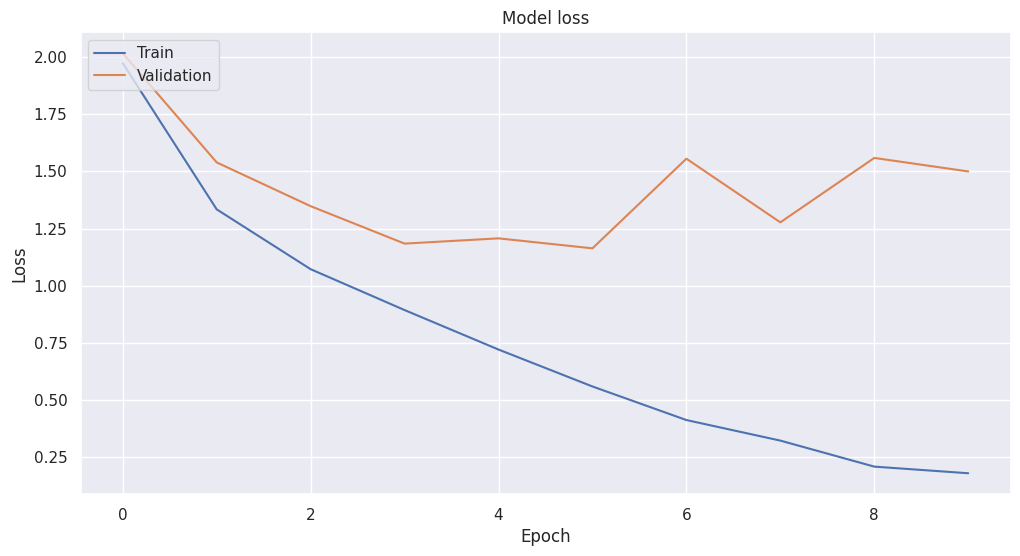

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       142
           1       0.90      0.56      0.69       161
           2       0.41      0.61      0.49        83
           3       0.62      0.36      0.45       118
           4       0.58      0.60      0.59       114
           5       0.72      0.75      0.73        81
           6       0.48      0.55      0.51       121
           7       0.72      0.52      0.60        50
           8       0.87      0.72      0.79       251
           9       0.69      0.89      0.78       132
          10       0.39      0.57      0.46       120

    accuracy                           0.65      1373
   macro avg       0.65      0.64      0.63      1373
weighted avg       0.69      0.65      0.66      1373



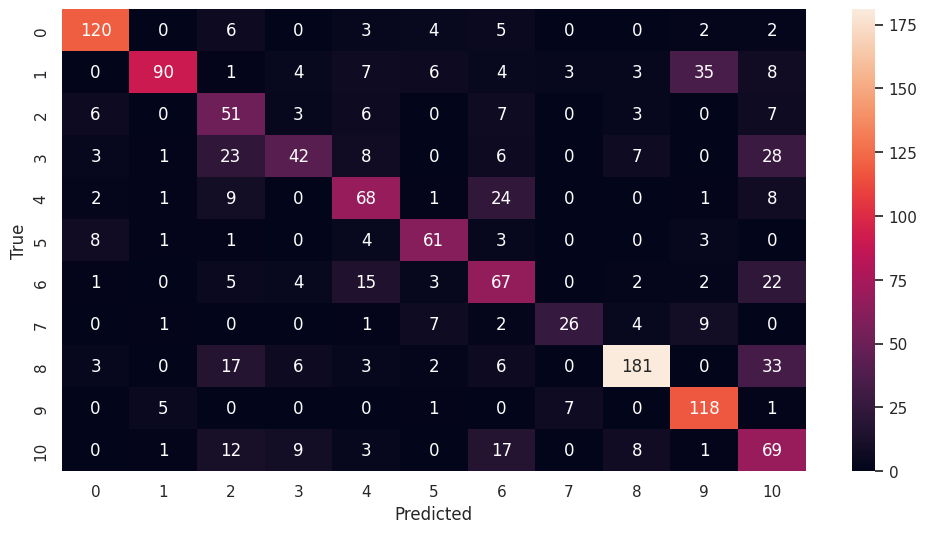

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
mse = np.mean((y_test - y_pred)**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.048681736083324934
